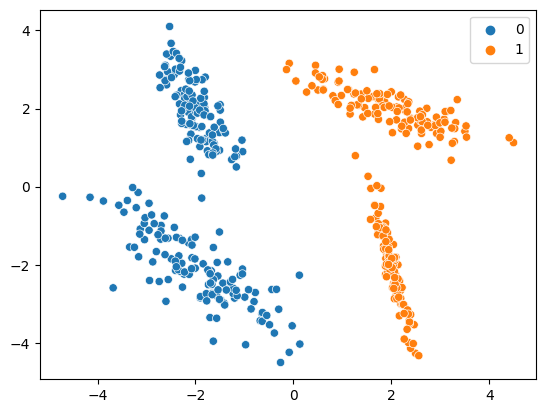

In [9]:
from sklearn.datasets import make_classification
import seaborn as sns
import numpy as np

# Generate Clean data
X,y = make_classification(n_samples=500, n_features=2, n_informative=2,n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=2,class_sep=2,flip_y=0,weights=[0.5,0.5], random_state=17)#

sns.scatterplot(x=X[:,0],y=X[:,1],hue=y);



In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(400, 100, 400, 100)

In [11]:
type(X_train)

numpy.ndarray

In [12]:
import torch
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)
X_test = torch.from_numpy(X_test).type(torch.float)
y_test =torch.from_numpy(y_test).type(torch.float)

In [18]:
#Building a model
import torch
from torch import nn
from torch.nn.functional import sigmoid

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device
#  cuda is a gpu. hai to use karo nai to cpu

'cpu'

In [19]:
type(nn)

module

In [20]:
# module is a model. or a nested model

In [21]:
class myModel(nn.Module): 
    ## nn.module is parent class. mymodel is a child class we are making by deriving from nn.module
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=4) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=4, out_features=1) # takes in 5 features, produces 1 feature (y)
    
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        z = self.layer_2(self.layer_1(x))
        return sigmoid(z) # computation goes through layer_1 first then the output of layer_1 goes through layer_2
        
# 4. Create an instance of the model and send it to target device
model_0 = myModel().to(device)
model_0

myModel(
  (layer_1): Linear(in_features=2, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=1, bias=True)
)

In [11]:
state_dict = model_0.state_dict()
print(state_dict)

OrderedDict([('layer_1.weight', tensor([[ 0.1505, -0.5286],
        [ 0.4860, -0.3962],
        [ 0.5330,  0.1694],
        [-0.4519, -0.5121]])), ('layer_1.bias', tensor([-0.1632, -0.2238, -0.2594, -0.1346])), ('layer_2.weight', tensor([[ 0.4730,  0.4353,  0.0602, -0.2115]])), ('layer_2.bias', tensor([-0.3110]))])


In [12]:
#Setup loss function and optimizer
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in
## loss func is assuming that no activation func has been applied.
## so it applies activation func khudse


# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [13]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [14]:
# Train model
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 1.2422],
        [ 1.3413],
        [-0.1993],
        [-1.3009],
        [-1.0709]], grad_fn=<SliceBackward0>)

In [15]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.7759],
        [0.7927],
        [0.4503],
        [0.2140],
        [0.2552]], grad_fn=<SigmoidBackward0>)

In [16]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [17]:
import torch
torch.manual_seed(42)
epochs = 5

# Put data to target device

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    #print(y_logits)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

   
    # Print out what's happening every epochs
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    state_dict = model_0.state_dict()
    print(state_dict)

Epoch: 0 | Loss: 0.39281, Accuracy: 93.75% | Test loss: 0.35917, Test acc: 94.00%
OrderedDict([('layer_1.weight', tensor([[ 0.1775, -0.5207],
        [ 0.5108, -0.3889],
        [ 0.5364,  0.1704],
        [-0.4640, -0.5157]])), ('layer_1.bias', tensor([-0.1648, -0.2254, -0.2596, -0.1339])), ('layer_2.weight', tensor([[ 0.4734,  0.4572,  0.0944, -0.2454]])), ('layer_2.bias', tensor([-0.3146]))])
Epoch: 1 | Loss: 0.35023, Accuracy: 96.25% | Test loss: 0.32587, Test acc: 97.00%
OrderedDict([('layer_1.weight', tensor([[ 0.2018, -0.5143],
        [ 0.5343, -0.3828],
        [ 0.5413,  0.1717],
        [-0.4766, -0.5190]])), ('layer_1.bias', tensor([-0.1658, -0.2263, -0.2598, -0.1334])), ('layer_2.weight', tensor([[ 0.4757,  0.4785,  0.1247, -0.2759]])), ('layer_2.bias', tensor([-0.3166]))])
Epoch: 2 | Loss: 0.31445, Accuracy: 97.00% | Test loss: 0.29731, Test acc: 97.00%
OrderedDict([('layer_1.weight', tensor([[ 0.2237, -0.5090],
        [ 0.5563, -0.3775],
        [ 0.5470,  0.1730],
    

In [18]:
loss = nn.CrossEntropyLoss()
output = loss(input, target)
output.backward()

NameError: name 'target' is not defined

In [19]:
print(input,'\n',y_test,'\n',output)

NameError: name 'output' is not defined